In [1]:
import numpy as np 
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
sns.set(style="whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

In [2]:
#Cargamos los datos
events = pd.read_csv('events.csv', low_memory = False)
#Cabecera
events.head(1)

,timestamp,event,person,url,sku,model,condition,storage,color,skus,...,search_engine,channel,new_vs_returning,city,region,country,device_type,screen_resolution,operating_system_version,browser_version
0,2018-05-31 23:38:05,ad campaign hit,0004b0a2,/comprar/iphone/iphone-5s,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#descarto las que no me interesan
events.drop(columns=['channel','condition','storage','color','campaign_source','search_engine','url','staticpage','skus','search_term','device_type','browser_version','operating_system_version','screen_resolution','new_vs_returning'],inplace=True)
#convierto los tipos
events.event = events.event.astype('category')
events.model = events.model.astype('category')
events.city = events.city.astype('category')
events.region = events.region.astype('category')
events.country = events.country.astype('category')

In [4]:
#pongo de index al datetime y agrego columnas para segmentar el tiempo
events.timestamp = pd.to_datetime(events['timestamp'],format='%Y-%m-%d %H:%M:%S')
events.set_index(pd.DatetimeIndex(events.timestamp),inplace=True)
events.drop(columns='timestamp',inplace=True)
events['date'] = events.index.date
events['year'] = events.index.year
events['month'] = events.index.month
events['day'] = events.index.day
events['hour'] = events.index.hour
events['minute'] = events.index.minute
events['week'] = events.index.weekofyear
events['weekday'] = events.index.weekday
events['weekday_name'] = events.index.weekday_name
events['weekday_name'] = pd.Categorical(events['weekday_name'], categories=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'], ordered=True)

events.sort_index(ascending=True,inplace=True)

events.head(1)

,event,person,sku,model,city,region,country,date,year,month,day,hour,minute,week,weekday,weekday_name
timestamp,,,,,,,,,,,,,,,,
2018-01-01 07:32:26,ad campaign hit,9250d410,NaN,NaN,NaN,NaN,NaN,2018-01-01,2018,1,1,7,32,1,0,Monday


In [5]:
#agrego una nueva columna que indica la quincena
array_quincena = ["1 Ene","2 Ene","1 Feb","2 Feb","1 Mar","2 Mar","1 Abr","2 Abr","1 May","2 May","1 Jun"]
events['fortnight'] = np.where(events['day'] <= 15, '1', '2')

In [6]:
events.tail(1)

,event,person,sku,model,city,region,country,date,year,month,day,hour,minute,week,weekday,weekday_name,fortnight
timestamp,,,,,,,,,,,,,,,,,
2018-06-15 23:59:31,checkout,208473cf,1325.0,iPhone 6,NaN,NaN,NaN,2018-06-15,2018,6,15,23,59,24,4,Friday,1


In [7]:
def plot_heatmap(data,title='Titulo',xlabel='Leyenda X',ylabel='Leyenda Y'):
    plt.figure(figsize = (18,9))
    ax = sns.heatmap(data, linewidth = 3, cmap = 'Greens')
    ax.set_title(title,Fontsize = 20)
    ax.set_ylabel(xlabel,Fontsize = 18)
    ax.set_xlabel(ylabel,fontsize = 18)

In [8]:
#todos los eventos, usuarios únicos, mes determinado
def heatmap_unique_users_between_dates(desde='2018-01-01 00:00:00',hasta='2018-07-01 00:00:00',title='Cantidad de usuarios por hora y día del mes'):
    filtro = events[(events.index > desde)]
    filtro = filtro[(filtro.index < hasta)]
    per_date_total = filtro.groupby(['day','hour']).agg({'person':'nunique'}).unstack()
    per_date_total.columns = per_date_total.columns.droplevel(0)
    per_date_total.fillna(value=0,inplace=True)
    per_date_total = per_date_total.astype(dtype='int64')
    unique_users = per_date_total.transpose()
    unique_users.sort_index(ascending=False,inplace=True)
    plot_heatmap(unique_users,title,'Hora del Día','Día del mes')

In [9]:
#armo la tabla por evento por dia del año (todos los datos)
per_event_datecount = events.groupby(['event','date']).agg({'date':'count'}).unstack()
per_event_datecount.columns = per_event_datecount.columns.droplevel(0)
per_event_datecount.fillna(value=0,inplace=True)
per_event_datecount = per_event_datecount.astype(dtype='int64')
#per_event_datecount

In [10]:
#armo la tabla por evento por semana
#descarto los ultimos y primeros dias para que sean semanas completas
filtro_semana = events[(events.index > '2018-01-15 00:00:00')]
per_event_weekcount = events.groupby(['event','week']).agg({'week':'count'}).unstack()
per_event_weekcount.columns = per_event_weekcount.columns.droplevel(0)
per_event_weekcount.fillna(value=0,inplace=True)
per_event_weekcount = per_event_weekcount.astype(dtype='int64')
#per_event_weekcount

In [11]:
#armo la tabla por evento por dia del mes
#filtro para que tener la misma cantidad de dias (salvo los 29,30,31 claro)
filtro_diames = events[(events.index < '2018-06-01 00:00:00')]
per_event_daycount = filtro_diames.groupby(['event','day']).agg({'day':'count'}).unstack()
per_event_daycount.columns = per_event_daycount.columns.droplevel(0)
per_event_daycount.fillna(value=0,inplace=True)
per_event_daycount = per_event_daycount.astype(dtype='int64')

In [12]:
#armo la tabla por evento, dia de la semana y hora
#descarto los ultimos y primeros dias para que sean semanas completas
per_event_hour_weekday = events.groupby(['event','weekday_name','hour']).agg({'hour':'count'}).unstack()
per_event_hour_weekday.columns = per_event_hour_weekday.columns.droplevel(0)
per_event_hour_weekday.fillna(value=0,inplace=True)
per_event_hour_weekday = per_event_hour_weekday.astype(dtype='int64')
per_event_hour_weekday.sort_index(inplace=True)

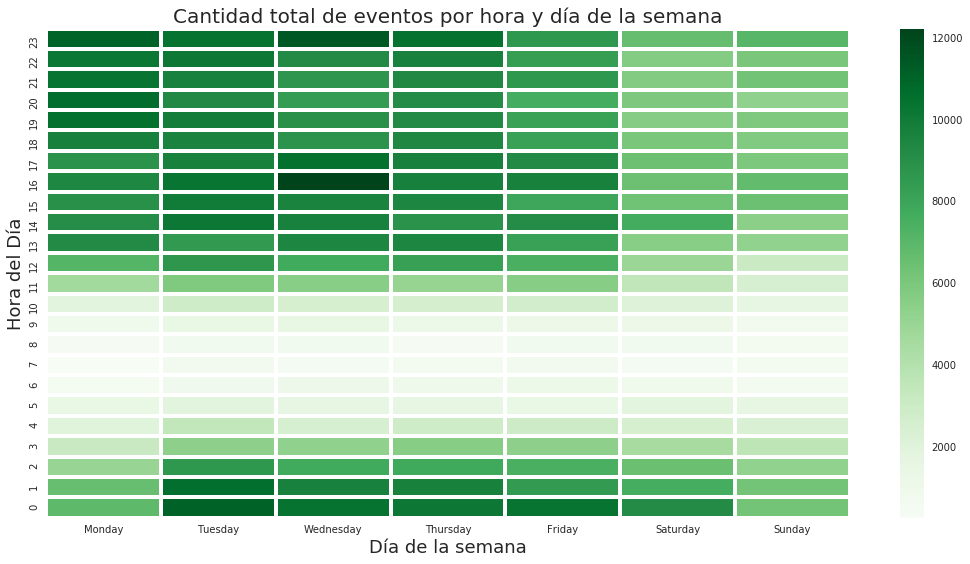

In [14]:
#Cantidad de eventos totales por hora y día de la semana
all_events_hour_weekday = events.groupby(['weekday_name','hour']).agg({'hour':'count'}).unstack()
all_events_hour_weekday.columns = all_events_hour_weekday.columns.droplevel(0)
all_events_hour_weekday.fillna(value=0,inplace=True)
all_events_hour_weekday = all_events_hour_weekday.astype(dtype='int64')
all_events_hour_weekday = all_events_hour_weekday.transpose()
all_events_hour_weekday.sort_index(inplace=True,ascending=False)
plot_heatmap(all_events_hour_weekday,'Cantidad total de eventos por hora y día de la semana','Hora del Día','Día de la semana')


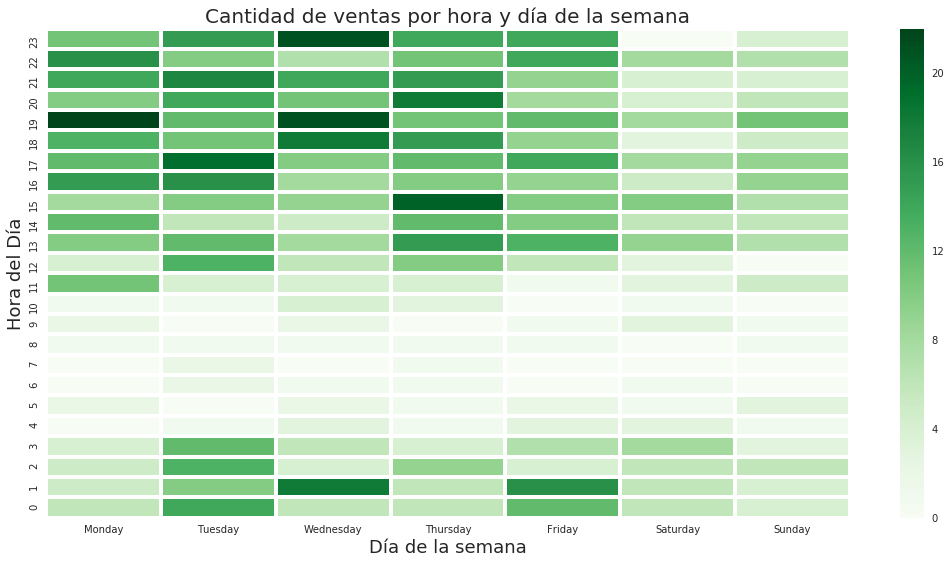

In [15]:
conversion = per_event_hour_weekday.loc['conversion'].transpose()
conversion.sort_index(ascending=False,inplace=True)
plot_heatmap(conversion,'Cantidad de ventas por hora y día de la semana','Hora del Día','Día de la semana')


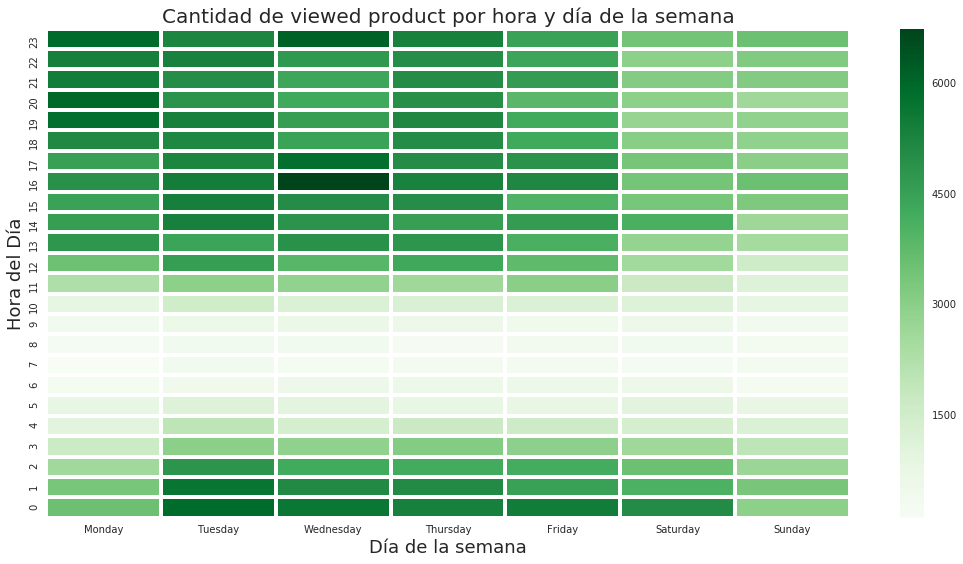

In [16]:
viewed = per_event_hour_weekday.loc['viewed product'].transpose()
viewed.sort_index(ascending=False,inplace=True)
plot_heatmap(viewed,'Cantidad de viewed product por hora y día de la semana','Hora del Día','Día de la semana')


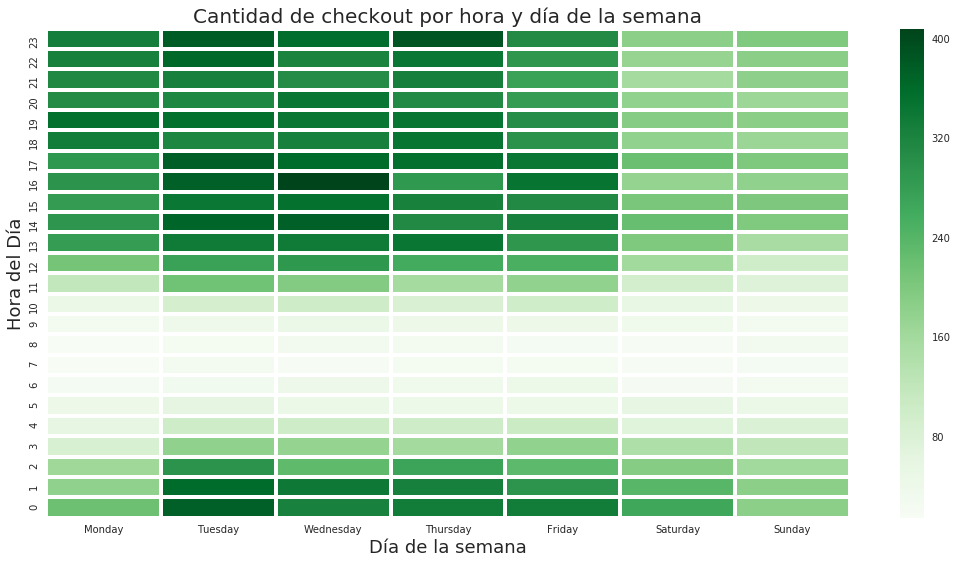

In [17]:
checkout = per_event_hour_weekday.loc['checkout'].transpose()
checkout.sort_index(ascending=False,inplace=True)
plot_heatmap(checkout,'Cantidad de checkout por hora y día de la semana','Hora del Día','Día de la semana')


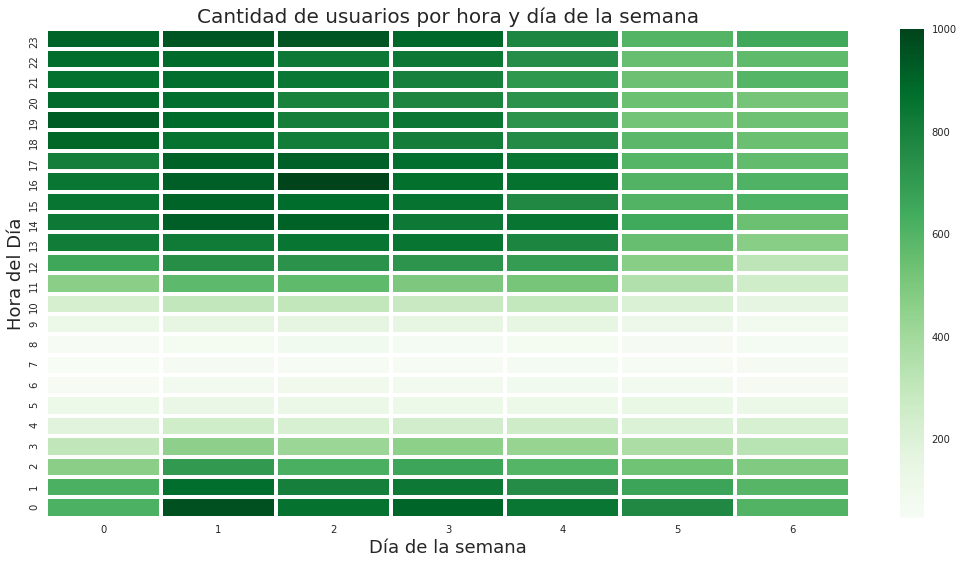

In [18]:
#todos los eventos, usuarios únicos
per_date_total = events.groupby(['weekday','hour']).agg({'person':'nunique'}).unstack()
per_date_total.columns = per_date_total.columns.droplevel(0)
per_date_total.fillna(value=0,inplace=True)
per_date_total = per_date_total.astype(dtype='int64')
unique_users = per_date_total.transpose()
unique_users.sort_index(ascending=False,inplace=True)
plot_heatmap(unique_users,'Cantidad de usuarios por hora y día de la semana','Hora del Día','Día de la semana')


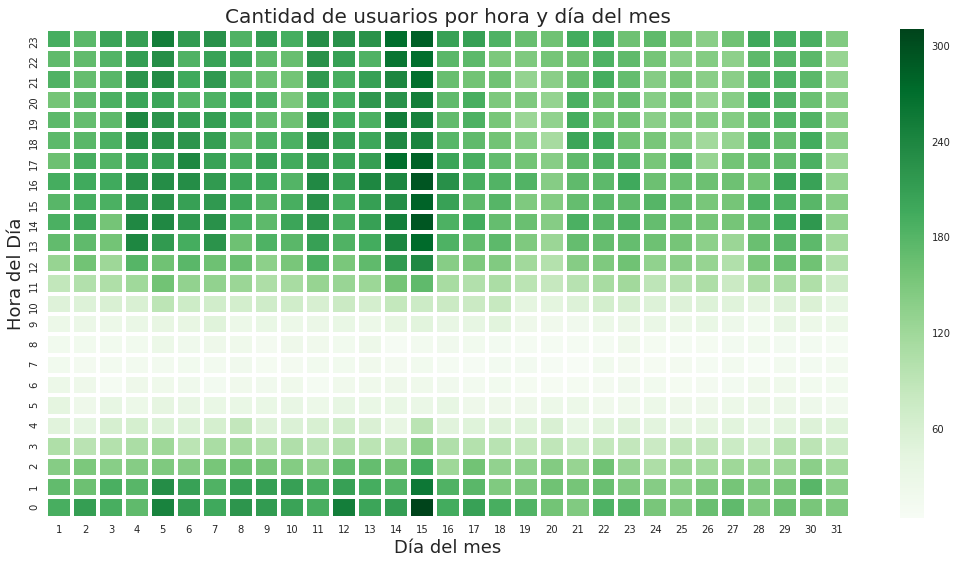

In [19]:
heatmap_unique_users_between_dates()


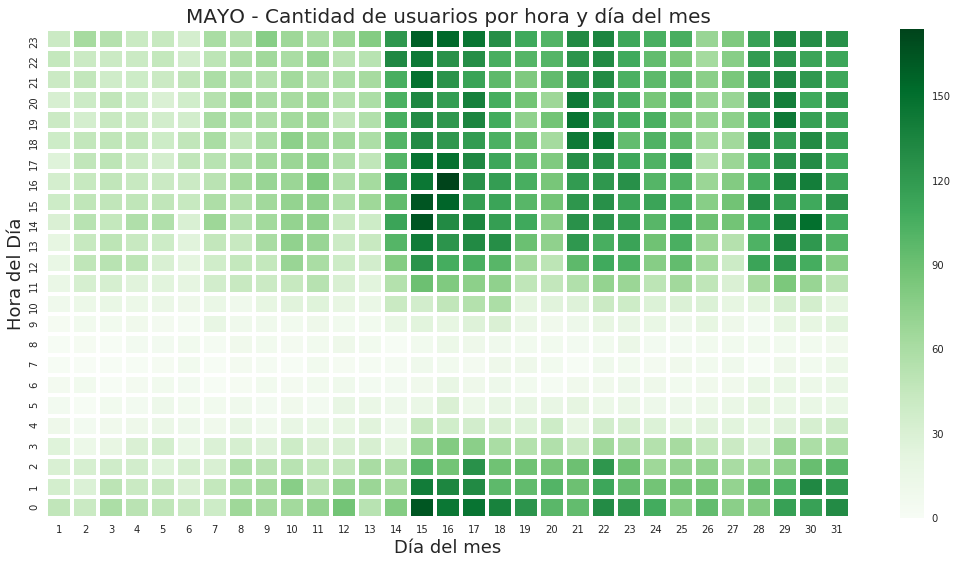

In [20]:
heatmap_unique_users_between_dates(desde='2018-05-01 00:00:00',hasta='2018-06-01 00:00:00',title='MAYO - Cantidad de usuarios por hora y día del mes')


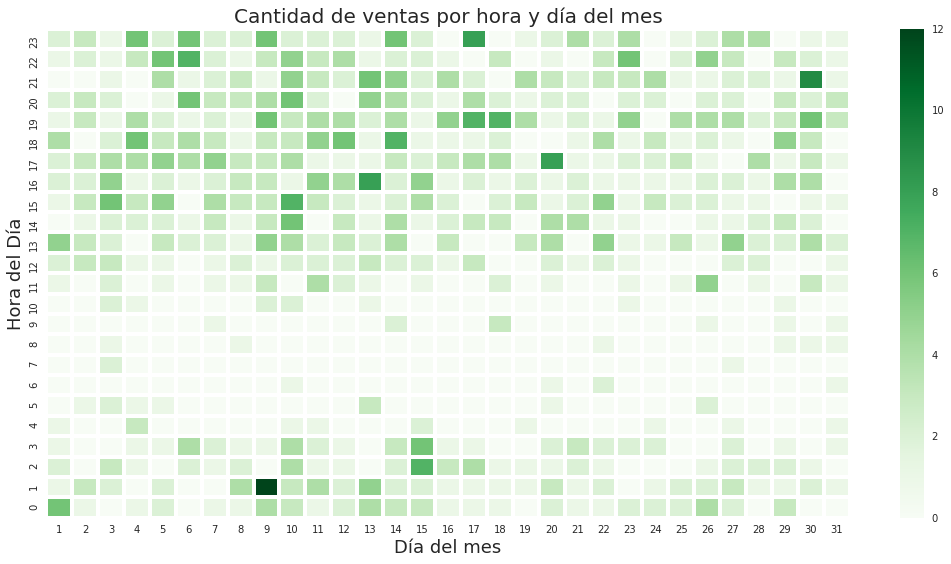

In [21]:
#conversion por hoy y dia del mes
conversiones = events.loc[events['event']=='conversion'].groupby(['day','hour']).agg({'hour':'count'}).unstack()
conversiones.columns = conversiones.columns.droplevel(0)
conversiones.fillna(value=0,inplace=True)
conversiones = conversiones.astype(dtype='int64')
conversiones = conversiones.transpose()
conversiones.sort_index(ascending=False,inplace=True)
plot_heatmap(conversiones,'Cantidad de ventas por hora y día del mes','Hora del Día','Día del mes')


In [23]:
def plot_fortnight(events, stacked=False, title='', y='', filename='generic'):
    meses = ['ENE','FEB','MAR','ABR','MAY','JUN']
    plot = events.unstack().plot(kind='bar',figsize = (22,11),fontsize=20,stacked = stacked)
    plot.set_xticklabels(meses,fontsize=20,rotation=0)
    plot.set_title(title,fontsize=22)
    plot.set_xlabel('Mes/Quincena',fontsize=20)
    plot.set_ylabel(y,fontsize=20)
    plot.legend(['1ra Quincena','2da Quincena'],fontsize=20,loc=(0.05,0.8))
    stacked_str = '_stacked' if stacked else ''

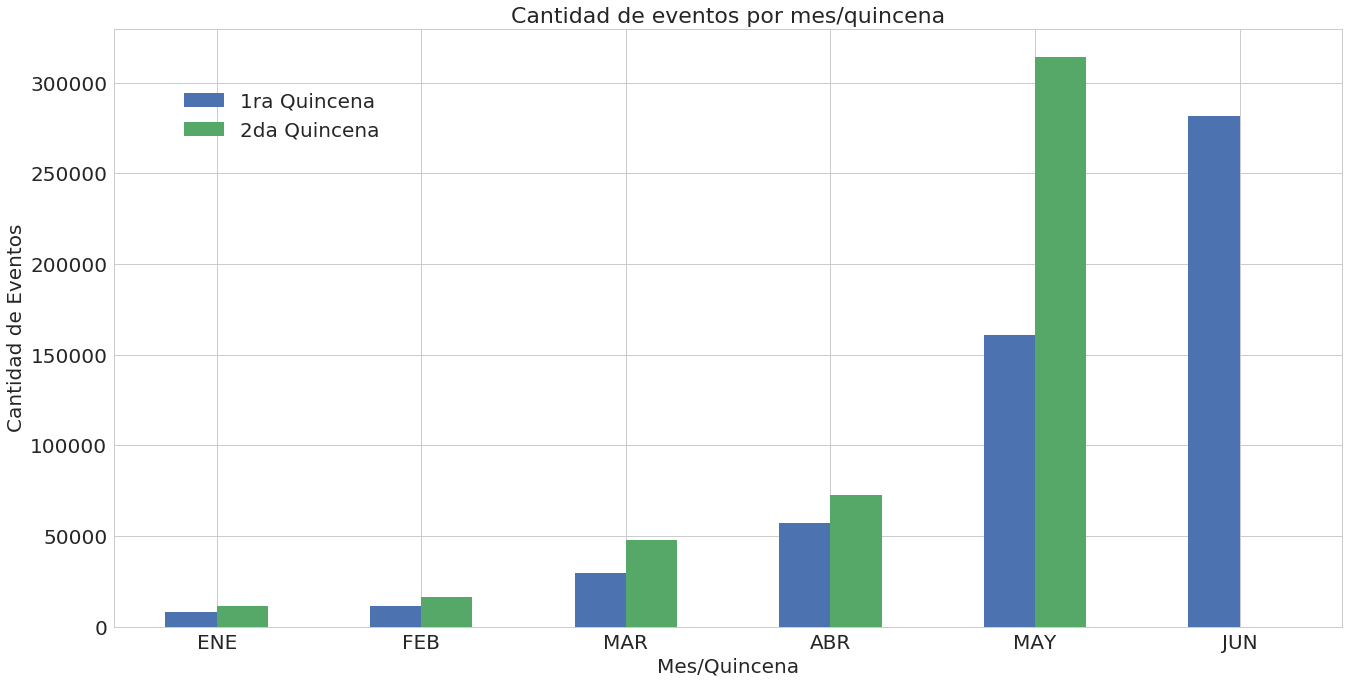

In [25]:
all_by_fortnight = events.groupby(['month','fortnight']).agg({'fortnight':'count'})
plot_fortnight(all_by_fortnight,title='Cantidad de eventos por mes/quincena',y='Cantidad de Eventos',filename='eventos')

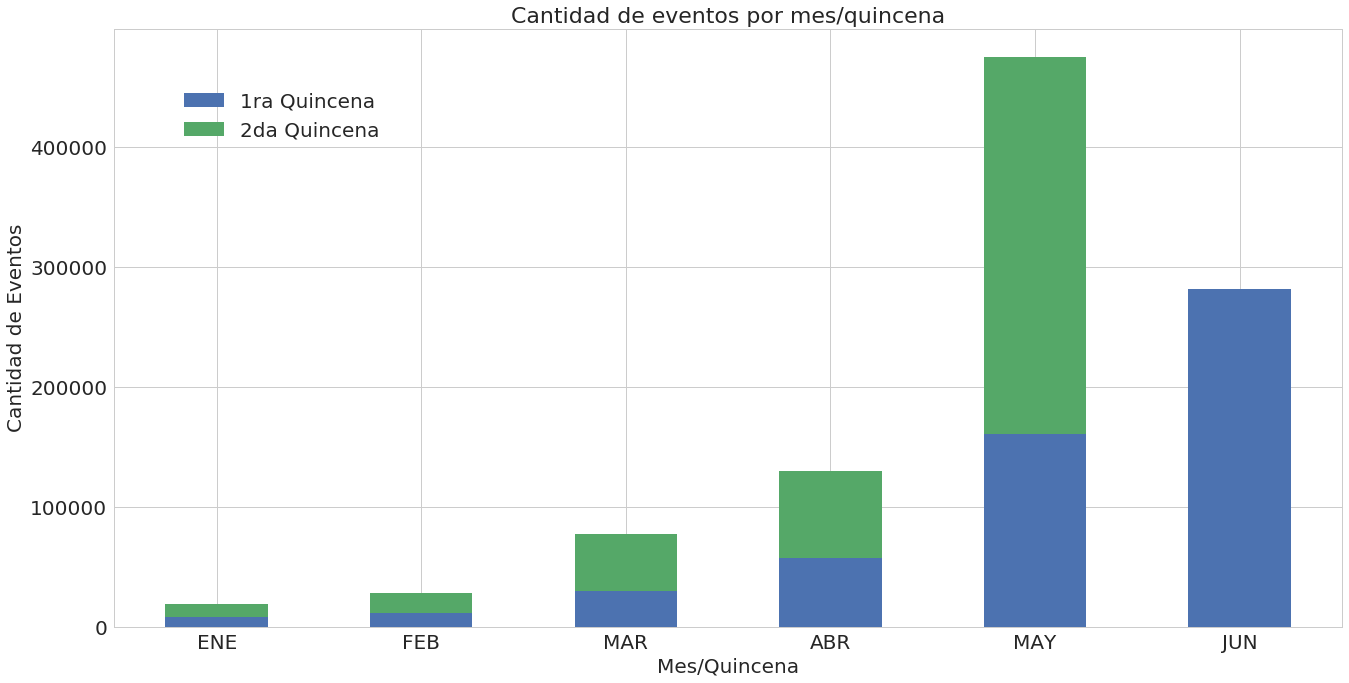

In [26]:
plot_fortnight(all_by_fortnight,stacked=True,title='Cantidad de eventos por mes/quincena',y='Cantidad de Eventos',filename='eventos')

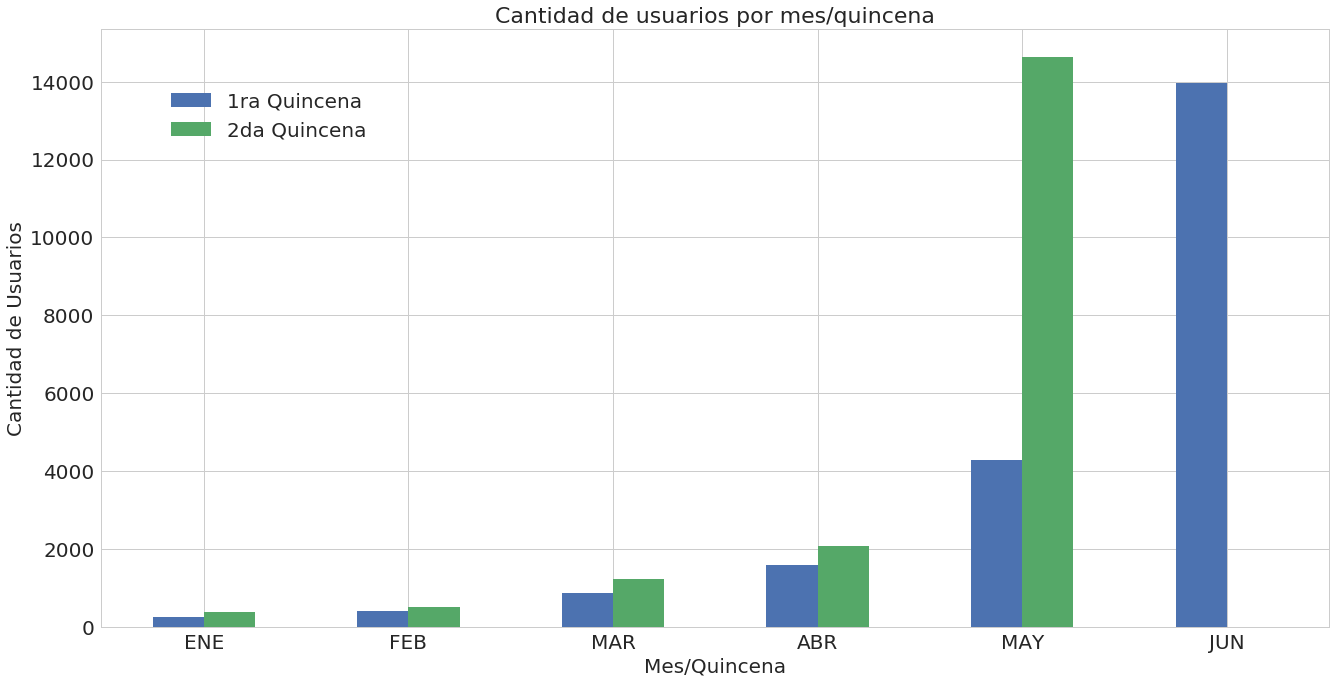

In [27]:
users_per_fortnight = events.groupby(['month','fortnight']).agg({'person':'nunique'})
plot_fortnight(users_per_fortnight,stacked=False,title='Cantidad de usuarios por mes/quincena',y='Cantidad de Usuarios',filename='eventos')

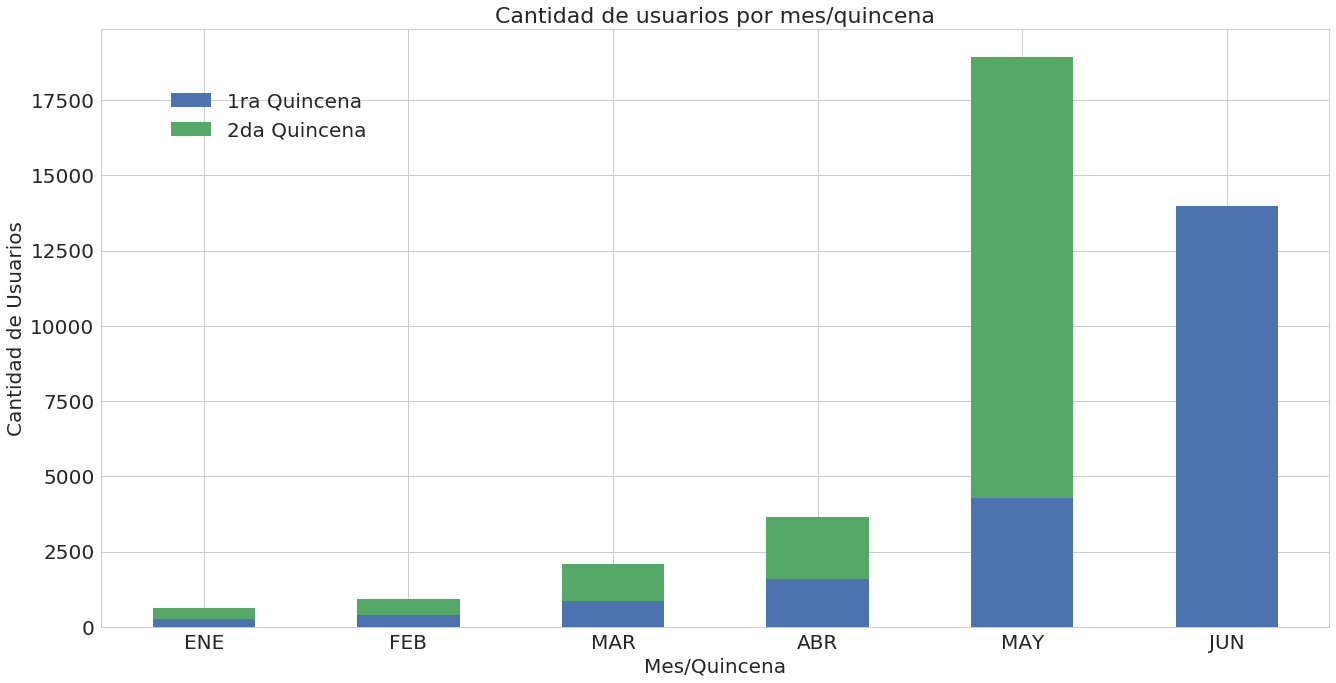

In [28]:
plot_fortnight(users_per_fortnight,stacked=True,title='Cantidad de usuarios por mes/quincena',y='Cantidad de Usuarios',filename='eventos')

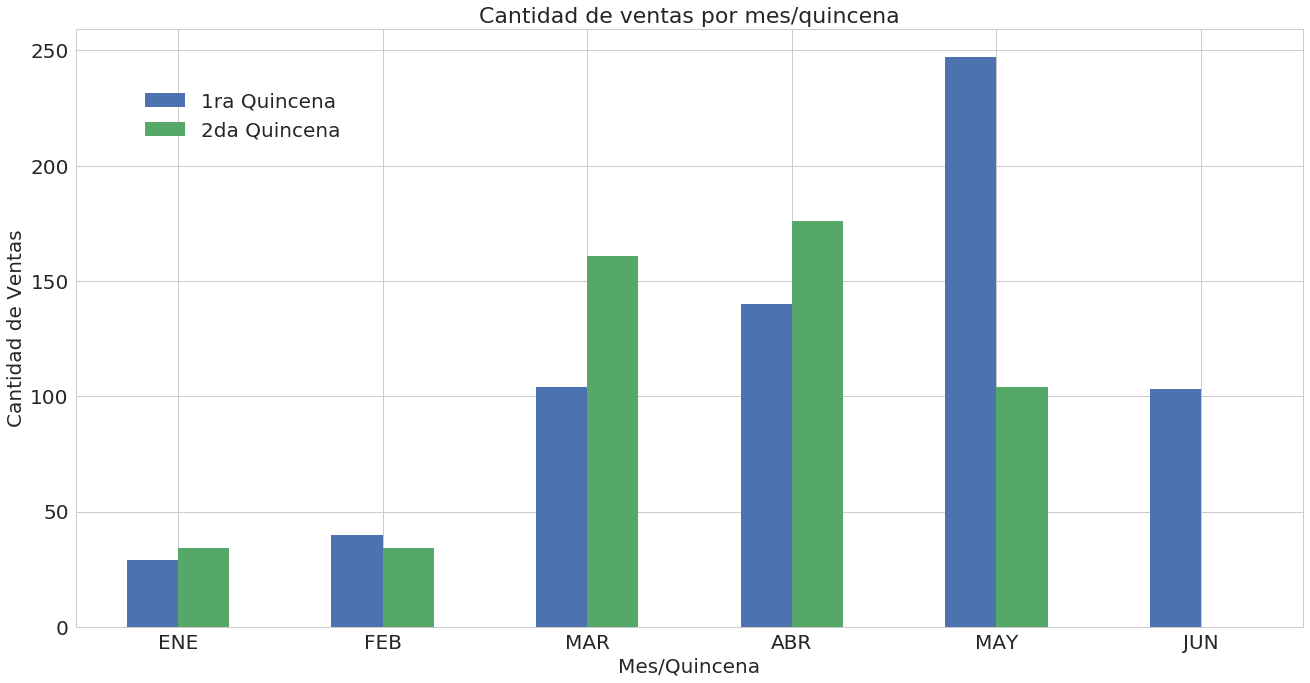

In [29]:
conversion_per_fortnight = events.loc[events['event']=='conversion'].groupby(['month','fortnight']).agg({'fortnight':'count'})
plot_fortnight(conversion_per_fortnight,stacked=False,title='Cantidad de ventas por mes/quincena',y='Cantidad de Ventas',filename='conversion')

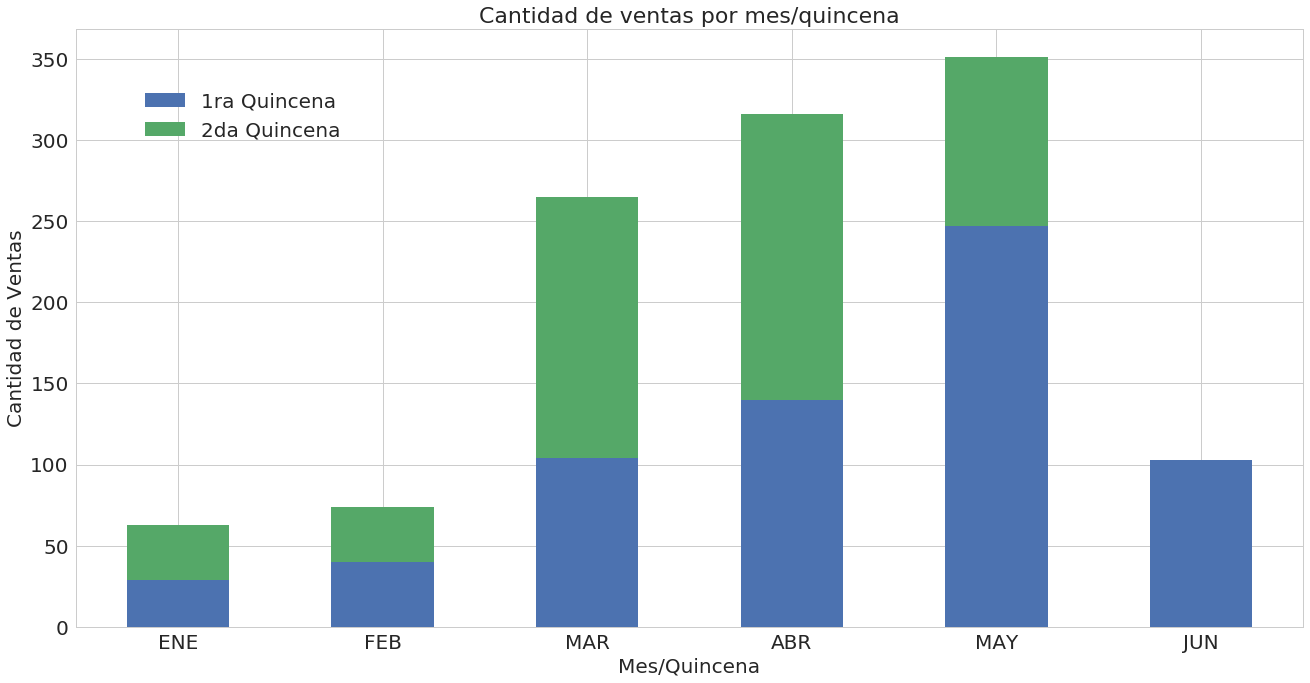

In [30]:
plot_fortnight(conversion_per_fortnight,stacked=True,title='Cantidad de ventas por mes/quincena',y='Cantidad de Ventas',filename='conversion')

Text(0,0.5,'Cantidad de eventos')

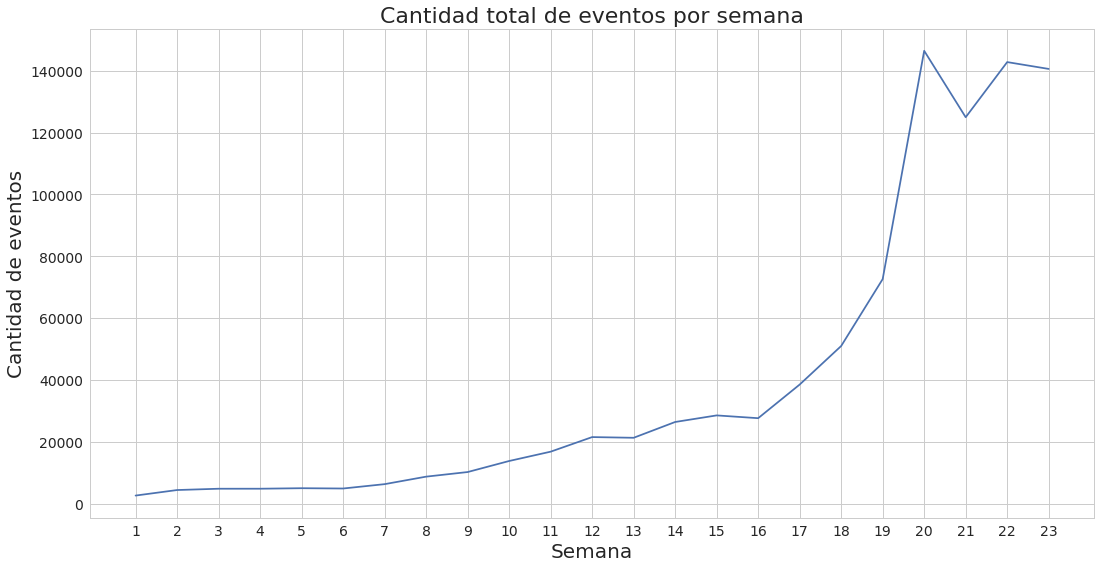

In [32]:
per_week_total_events = events.groupby(['week']).agg({'event':'count'}).unstack()
per_week_total_events.index = per_week_total_events.index.droplevel(0)
per_week_total_events.drop(24,inplace=True)
plot = per_week_total_events.plot(figsize=(18,9),grid=True,fontsize=14,xticks=per_week_total_events.index)
plot.set_title('Cantidad total de eventos por semana',fontsize=22)
plot.set_xlabel('Semana',fontsize=20)
plot.set_ylabel('Cantidad de eventos',fontsize=20)

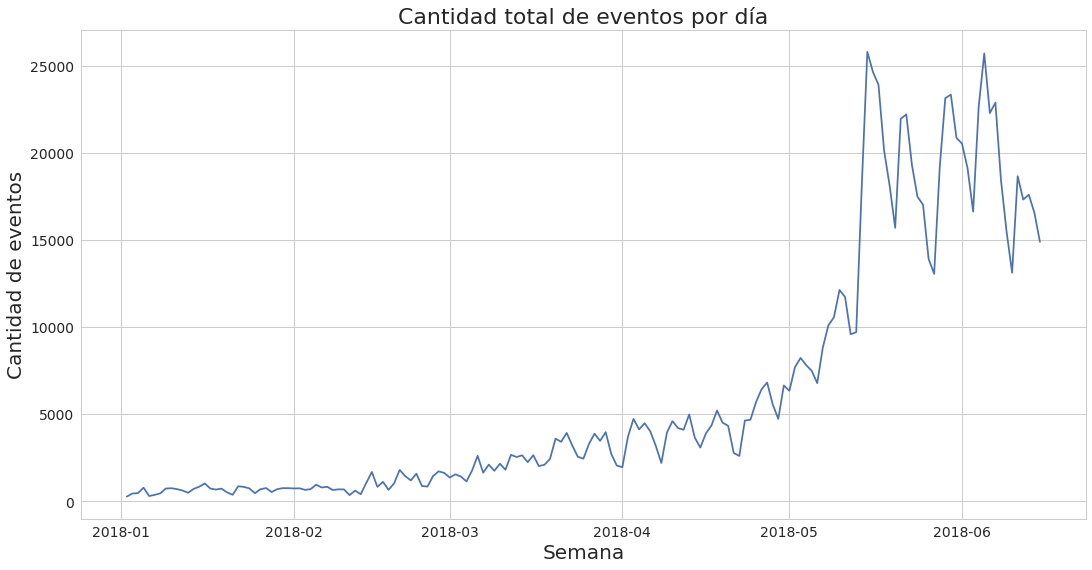

In [33]:
filtro_date = events[(events.index > '2018-01-02 00:00:00')]#no miro el 1/1/18 porque no es representativo
per_date_total_events = filtro_date.groupby(['date']).agg({'date':'count'})
plot = per_date_total_events.plot(figsize=(18,9),grid=True,fontsize=14)
plot.set_title('Cantidad total de eventos por día',fontsize=22)
plot.set_xlabel('Semana',fontsize=20)
plot.set_ylabel('Cantidad de eventos',fontsize=20)
plot.legend('')

Text(0,0.5,'Cantidad de usuarios')

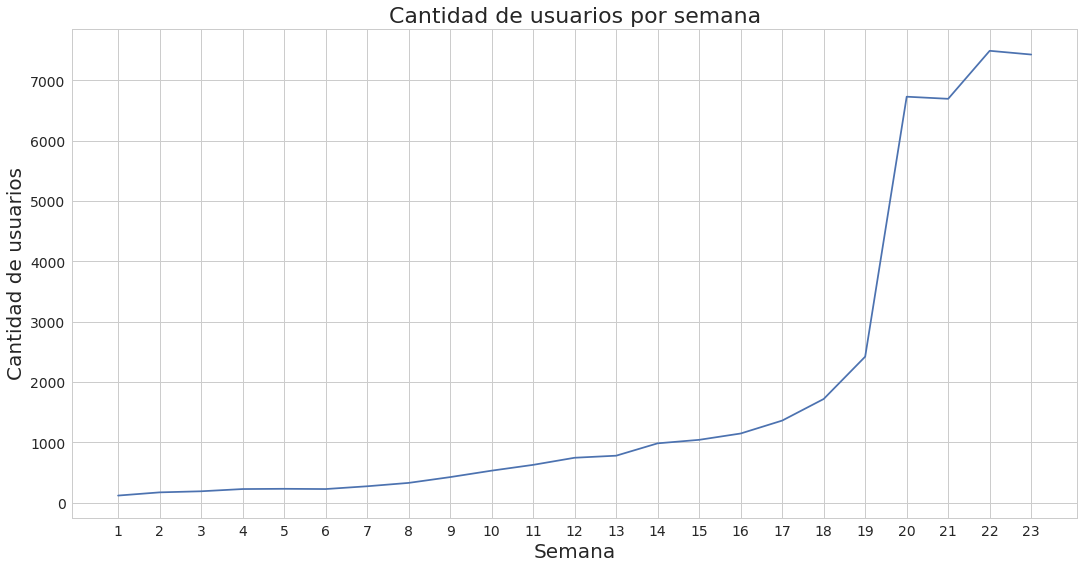

In [34]:
per_week_total_unique = events.groupby(['week']).agg({'person':'nunique'}).unstack()
per_week_total_unique.index = per_week_total_unique.index.droplevel(0)
per_week_total_unique.drop(24,inplace=True)
plot = per_week_total_unique.plot(logy=False,figsize=(18,9),grid=True,fontsize=14,xticks=per_week_total_unique.index)
plot.set_title('Cantidad de usuarios por semana',fontsize=22)
plot.set_xlabel('Semana',fontsize=20)
plot.set_ylabel('Cantidad de usuarios',fontsize=20)